In [7]:
from packaging import version

import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from scipy import stats
import tensorboard as tb
from stable_baselines3 import SAC, PPO, A2C

import os
import sys
import time
import subprocess
from PIL import Image
import numpy as np
import torch
import yaml
from torchvision import transforms
from experiment import VAEXperiment
from models import *

import gymnasium as gym
from gymnasium import ObservationWrapper
from gymnasium.wrappers import PixelObservationWrapper, FrameStack
from gymnasium.spaces import Box, Discrete

from stable_baselines3 import SAC, PPO, A2C
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.vec_env import DummyVecEnv, SubprocVecEnv
from stable_baselines3.common.utils import set_random_seed
from stable_baselines3.common.callbacks import CallbackList, CheckpointCallback, EvalCallback
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.evaluation import evaluate_policy

In [58]:
from tbparse import SummaryReader
log_dir = "RLmodels/MountainCarContinuous-v0/Double_loop/logs/BCE_VAE_l3_test2_PPO_v1__0vae_resets__0rl_resets___0"
reader = SummaryReader(log_dir)
df = reader.scalars
print(df)

      step                  tag       value
0     1008  rollout/ep_len_mean  999.000000
1     1016  rollout/ep_len_mean  999.000000
2     1024  rollout/ep_len_mean  999.000000
3     1032  rollout/ep_len_mean  999.000000
4     1040  rollout/ep_len_mean  999.000000
...    ...                  ...         ...
3248  2976     train/value_loss    0.000313
3249  2984     train/value_loss    0.000090
3250  2992     train/value_loss    0.000022
3251  3000     train/value_loss    0.000013
3252  3008     train/value_loss    0.000011

[3253 rows x 3 columns]


In [55]:
tags = pd.DataFrame()
tags = df.groupby(['tag'])

In [59]:
for key, group in tags:
    print(key)
    if key == ('rollout/ep_len_mean',):
        ep_len = group
        print(ep_len)
    if key == ('rollout/ep_rew_mean',):
        ep_rew = group
        print(ep_rew)

('rollout/ep_len_mean',)
     step                  tag  value
0    3016  rollout/ep_len_mean  999.0
1    3024  rollout/ep_len_mean  999.0
2    3032  rollout/ep_len_mean  999.0
3    3040  rollout/ep_len_mean  999.0
4    3048  rollout/ep_len_mean  999.0
..    ...                  ...    ...
497  6992  rollout/ep_len_mean  999.0
498  7000  rollout/ep_len_mean  999.0
499  7008  rollout/ep_len_mean  999.0
500  7016  rollout/ep_len_mean  999.0
501  7024  rollout/ep_len_mean  999.0

[502 rows x 3 columns]
('rollout/ep_rew_mean',)
      step                  tag      value
502   3016  rollout/ep_rew_mean  -7.563651
503   3024  rollout/ep_rew_mean  -7.563651
504   3032  rollout/ep_rew_mean  -7.563651
505   3040  rollout/ep_rew_mean  -7.563651
506   3048  rollout/ep_rew_mean  -7.563651
...    ...                  ...        ...
999   6992  rollout/ep_rew_mean -12.573076
1000  7000  rollout/ep_rew_mean -12.573076
1001  7008  rollout/ep_rew_mean -14.787804
1002  7016  rollout/ep_rew_mean -14.7878

In [50]:
ep_rew['value']

1   -3.531628
Name: value, dtype: float64

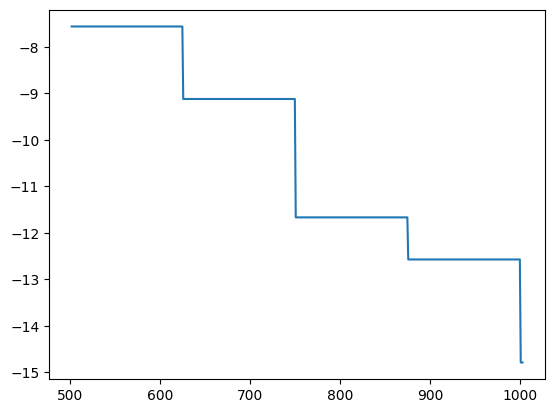

In [60]:
plt.plot(ep_rew['value'])

In [3]:
def eval_agent(agent, env, n_eval_episodes):
    total_rewards = []
    device = 'cpu'
    policy = agent.policy.to(device)  # Move observation to the same device as the model
    observation_space = env.observation_space
    print('observation space:', observation_space)
    
    for episode in range(n_eval_episodes):
        observation, info = env.reset()
        
        episode_reward = 0
        done = False

        while not done: 
            
            action = policy.predict(observation, deterministic=True)
            #print(action)
            observation, reward, terminated, truncated, info = env.step(action[0])
           
            observation =observation.reshape(2)
            if not observation_space.contains(observation):
                print("Observation is not valid:", observation)
            episode_reward += reward
            if terminated:
                done = True
            if truncated:
                done = True                   

        total_rewards.append(episode_reward)

    total_rewards = np.array(total_rewards)
    
    agent.policy.to('cuda')
    return np.mean(total_rewards), np.std(total_rewards), total_rewards

In [12]:
#agent_dir = 'RLmodels/MountainCarContinuous-v0/PPO_tuned_OG/PPO_tuned_OG3.zip'
#agent = PPO.load(agent_dir)

        #make env
env = gym.make("MountainCarContinuous-v0",
                    render_mode ='rgb_array')

In [135]:
rweard, std, alle = eval_agent(agent, env,1000)

observation space: Box([-1.2  -0.07], [0.6  0.07], (2,), float32)


KeyboardInterrupt: 

In [ ]:
rweard

In [ ]:
std

In [ ]:
agents_dir = 'RLmodels/MountainCarContinuous-v0/PPO_tuned_OG'
plt.savefig('agent_performance_plot.png', bbox_inches='tight'
agent_names=[]
rewards = []
std_values = []
all_values = []

for agent_name in os.listdir(agents_dir):
    print(agent_name)
    agent = PPO.load(os.path.join(agents_dir, agent_name))
    reward, std, all_values_single = eval_agent(agent, env, 100)
    print(reward, std)
    rewards.append(reward)
    std_values.append(std)
    all_values.append(all_values_single)
    

observation space: Box([-1.2  -0.07], [0.6  0.07], (2,), float32)
observation space: Box([-1.2  -0.07], [0.6  0.07], (2,), float32)
observation space: Box([-1.2  -0.07], [0.6  0.07], (2,), float32)
observation space: Box([-1.2  -0.07], [0.6  0.07], (2,), float32)
observation space: Box([-1.2  -0.07], [0.6  0.07], (2,), float32)
observation space: Box([-1.2  -0.07], [0.6  0.07], (2,), float32)
observation space: Box([-1.2  -0.07], [0.6  0.07], (2,), float32)
observation space: Box([-1.2  -0.07], [0.6  0.07], (2,), float32)
observation space: Box([-1.2  -0.07], [0.6  0.07], (2,), float32)
observation space: Box([-1.2  -0.07], [0.6  0.07], (2,), float32)


NameError: name 'all_agents_data' is not defined

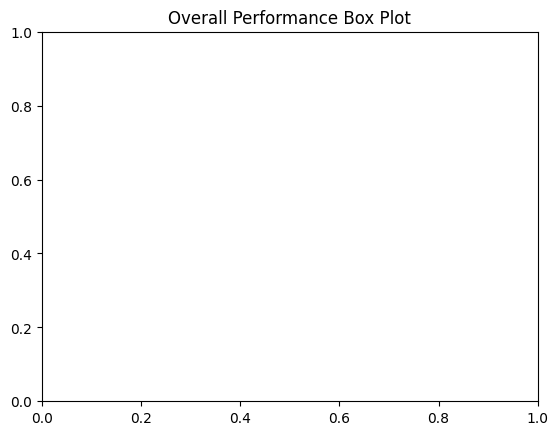

In [139]:
agents_data = []

for agent_name in os.listdir(agents_dir):
    agent = PPO.load(os.path.join(agents_dir, agent_name))
    reward, std, all_values_single = eval_agent(agent, env, 100)
    
    agents_data.append({'name': agent_name, 'reward': reward, 'std': std, 'rewards': all_values_single})

# Create a figure and axis for the overall box plot
fig1, ax1 = plt.subplots()
ax1.set_title('Overall Performance Box Plot')

# Extract rewards data for all agents together
all_rewards_data = [data['rewards'] for data in agents_data]

# Create a box plot for all agents
ax1.boxplot(all_rewards_data)
ax1.set_xticklabels([data['name'] for data in agents_data], rotation=45, ha="right")

plt.show()

# Create individual box plots for each agent
for agent_data in agents_data:
    fig, ax = plt.subplots()
    ax.set_title(f'Performance Box Plot - {agent_data["name"]}')
    ax.boxplot(agent_data['rewards'])
    plt.show()

In [ ]:
agents_data = []
agents_dir = 'RLmodels/MountainCarContinuous-v0/PPO_tuned_OG'
for agent_name in os.listdir(agents_dir):
    agent = PPO.load(os.path.join(agents_dir, agent_name))
    reward, std, all_values_single = eval_agent(agent, env, 200)
    
    agents_data.append({'name': agent_name, 'reward': reward, 'std': std, 'rewards': all_values_single})


# Create a figure and axis for the overall box plot
fig1, ax1 = plt.subplots()
ax1.set_title('Overall Performance Box Plot')

# Extract rewards data for all agents together
all_rewards_data = [data['rewards'] for data in agents_data]

# Create a box plot for all agents
ax1.boxplot(all_rewards_data)
ax1.set_xticklabels([data['name'] for data in agents_data], rotation=45, ha="right")

plt.show()

# Create individual box plots for each agent
for agent_data in agents_data:
    fig, ax = plt.subplots()
    ax.set_title(f'Performance Box Plot - {agent_data["name"]}')
    ax.boxplot(agent_data['rewards'])
    plt.show()

observation space: Box([-1.2  -0.07], [0.6  0.07], (2,), float32)
observation space: Box([-1.2  -0.07], [0.6  0.07], (2,), float32)
observation space: Box([-1.2  -0.07], [0.6  0.07], (2,), float32)
observation space: Box([-1.2  -0.07], [0.6  0.07], (2,), float32)
observation space: Box([-1.2  -0.07], [0.6  0.07], (2,), float32)
observation space: Box([-1.2  -0.07], [0.6  0.07], (2,), float32)
observation space: Box([-1.2  -0.07], [0.6  0.07], (2,), float32)
observation space: Box([-1.2  -0.07], [0.6  0.07], (2,), float32)
observation space: Box([-1.2  -0.07], [0.6  0.07], (2,), float32)


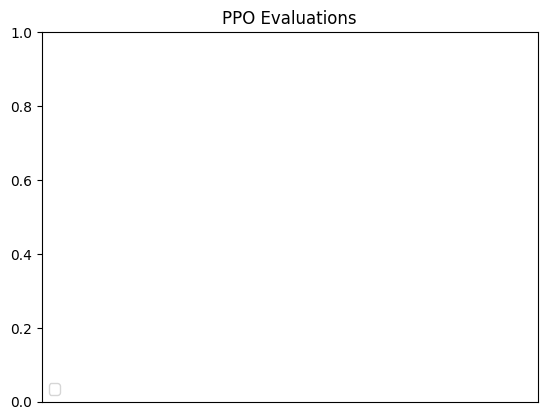

In [9]:
# Create a figure and axis
fig, ax = plt.subplots()
ax.set_title('PPO Evaluations')

for agent_data in agents_data:
    rewards = agent_data['rewards']
    mean_reward = np.mean(rewards)
    std_reward = np.std(rewards)
    
    # Plot individual data points
    ax.scatter([agent_data['name']] * len(rewards), rewards, color='lightblue', alpha=0.5)
    
    # Plot the mean reward as a red line
    ax.plot([agent_data['name']], [mean_reward], marker='o', markersize=5, color='orange')
    
    # Plot error bars for the standard deviation
    ax.errorbar([agent_data['name']], [mean_reward], yerr=std_reward, color='orange')

# Set x-axis ticks and labels
ax.set_xticks(range(len(agents_data)))
ax.set_xticklabels([data['name'][:-4] for data in agents_data], rotation=45, ha="right")

# Add a legend outside the loop
ax.legend(['Episode Reward','Mean Reward (std)'], loc='lower left')
plt.savefig('PPO Evaluations Rewards of 200 Episodes.png', bbox_inches='tight')
plt.show()

In [168]:
agents_dir = 'RLmodels/MountainCarContinuous-v0/SAC_tuned_OG'
agent_names=[]
rewards = []
std_values = []
all_values = []
agents_data =[]
for agent_name in os.listdir(agents_dir):
    agent = SAC.load(os.path.join(agents_dir, agent_name))
    reward, std, all_values_single = eval_agent(agent, env, 200)
    
    agents_data.append({'name': agent_name, 'reward': reward, 'std': std, 'rewards': all_values_single})

observation space: Box([-1.2  -0.07], [0.6  0.07], (2,), float32)
observation space: Box([-1.2  -0.07], [0.6  0.07], (2,), float32)
observation space: Box([-1.2  -0.07], [0.6  0.07], (2,), float32)
observation space: Box([-1.2  -0.07], [0.6  0.07], (2,), float32)
observation space: Box([-1.2  -0.07], [0.6  0.07], (2,), float32)
observation space: Box([-1.2  -0.07], [0.6  0.07], (2,), float32)
observation space: Box([-1.2  -0.07], [0.6  0.07], (2,), float32)
observation space: Box([-1.2  -0.07], [0.6  0.07], (2,), float32)
observation space: Box([-1.2  -0.07], [0.6  0.07], (2,), float32)
observation space: Box([-1.2  -0.07], [0.6  0.07], (2,), float32)


<Figure size 640x480 with 0 Axes>

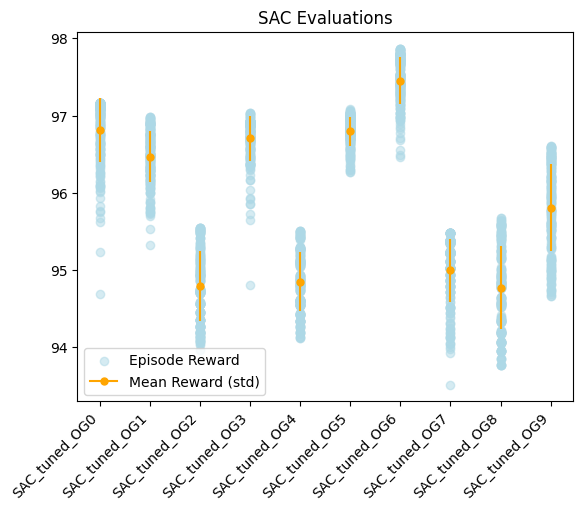

In [169]:
# Create a figure and axis
plt.clf()
fig, ax = plt.subplots()
ax.set_title('SAC Evaluations')

for agent_data in agents_data:
    rewards = agent_data['rewards']
    mean_reward = np.mean(rewards)
    std_reward = np.std(rewards)
    
    # Plot individual data points
    ax.scatter([agent_data['name']] * len(rewards), rewards, color='lightblue', alpha=0.5)
    
    # Plot the mean reward as a red line
    ax.plot([agent_data['name']], [mean_reward], marker='o', markersize=5, color='orange')
    
    # Plot error bars for the standard deviation
    ax.errorbar([agent_data['name']], [mean_reward], yerr=std_reward, color='orange')

# Set x-axis ticks and labels
ax.set_xticks(range(len(agents_data)))
ax.set_xticklabels([data['name'][:-4] for data in agents_data], rotation=45, ha="right")

# Add a legend outside the loop
ax.legend(['Episode Reward','Mean Reward (std)'], loc='lower left')
plt.savefig('SAC Evaluations Rewards of 200 Episodes.png')
plt.show()